In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from mpl_toolkits.mplot3d.axes3d import Axes3D


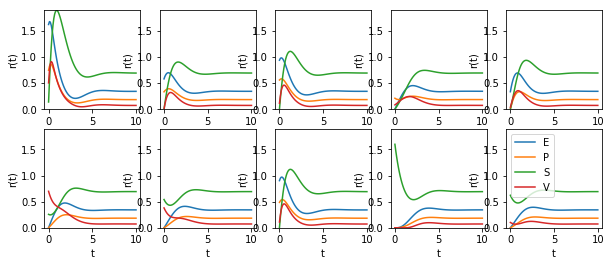

In [6]:
# Neuron labels
labels = ['E', 'P', 'S', 'V'];
D = len(labels);

# Specify weight matrix parameters
E_pre = 1.0;
W_EE = E_pre;
W_EP = 1.0;
W_ES = 0.54;

W_PE = E_pre;
W_PP = 1.01;
W_PS = 0.33;

W_SE = E_pre;
W_SV = 0.15;

W_VE = E_pre;
W_VP = 0.22;
W_VS = 0.77;

# define weight matrix placeholder
W = tf.placeholder(tf.float64, shape=(D,D));
_W = np.array([[W_EE, -W_EP, -W_ES,   0.0], \
               [W_PE, -W_PP, -W_PS,   0.0], \
               [W_SE,   0.0,   0.0, -W_SV], \
               [W_VE, -W_VP, -W_VS,   0.0]]);

# define input
h_common = 0.5;
h_E = 0.3 + h_common;
h_P = 0.0 + h_common;
h_S = 0.0 + h_common;
h_V = 0.0 + h_common;
h = np.expand_dims(np.array([h_E, h_P, h_S, h_V]), 1);

# initial conditions
num_init_conds = 10;
r0s = [];
for i in range(num_init_conds):
    r0_i = np.random.normal(.2, .5, [4,1]);
    r0_i[r0_i < 0.0] = 0.0;
    r0s.append(r0_i);
    
# time points of simulation
dt = 0.1;
t_ss = 10.0;
_t = np.arange(0,t_ss+dt, dt);
t = tf.placeholder(tf.float64, shape=(None,));

# transition function
n = 2.0;
tau = 0.1;
def f(y, t):
    return (1.0 / tau) * (-y + tf.pow(tf.nn.relu(tf.matmul(W, y) + h), n));

# simulate system
r_ts  = []
for i in range(num_init_conds):
    r_ts.append(tf.contrib.integrate.odeint_fixed(f, r0s[i], t, method='rk4'));
    
with tf.Session() as sess:
    _r_ts = sess.run(r_ts, {W:_W, t:_t});
    
    min_val = min(map(np.min, _r_ts));
    max_val = max(map(np.max, _r_ts));
              
    plt.figure(figsize=(10,4));
    for i in range(num_init_conds):
        plt.subplot(2,num_init_conds//2,i+1);
        _r_t = _r_ts[i];
        for j in range(D):
            plt.plot(_t, _r_t[:,j], label=labels[j]);
        plt.ylim([min_val, max_val]);
        plt.xlabel('t');
        plt.ylabel('r(t)');
    plt.legend();
    plt.show();

1.0 0.1
1.0 0.5
1.0 1.0
2.0 0.1
2.0 0.5
2.0 1.0
5.0 0.1
5.0 0.5
5.0 1.0
10.0 0.1
10.0 0.5
10.0 1.0


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


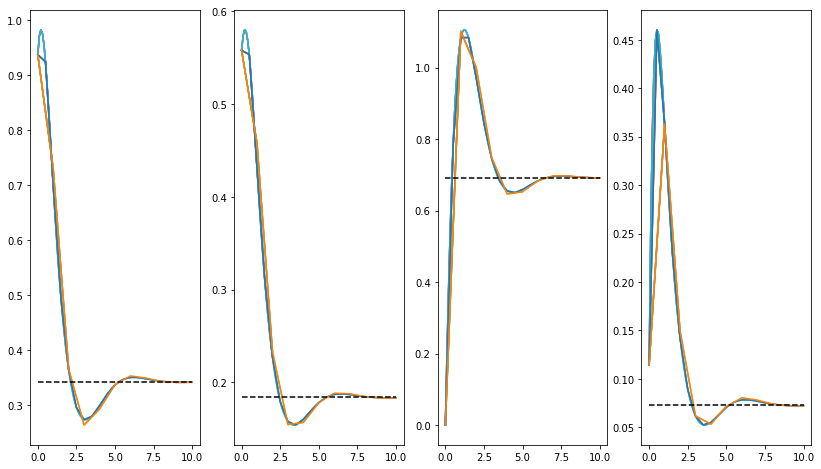

In [7]:
# assess simulation fixed point fidelity over durations and simulation resolutions
t_ss_list = [1.0, 2.0, 5.0, 10.0];
dts = [0.1, 0.5, 1.0];
num_t_ss = len(t_ss_list);
num_dts = len(dts);

all_ts = []
for i in range(num_t_ss):
    t_ss = t_ss_list[i];
    t_is = [];
    for j in range(num_dts):
        dt = dts[j];
        t_ij = np.arange(0,t_ss+dt, dt);
        t_is.append(t_ij);
    all_ts.append(t_is);
    
# simulation timescale for ground truth
dt_gt = .001;
t_ss_gt = 20;
t_gt = np.arange(0,t_ss_gt+dt_gt, dt_gt);

plot_ind = 2;
with tf.Session() as sess:
    # get the ground truth first
    _r_ts = sess.run(r_ts, {W:_W, t:t_gt});
    r_ss_gt = [];
    for k in range(num_init_conds):
        r_ss_gt.append(_r_ts[k][-1,:]);
    
    FP_MSE  = np.zeros((num_t_ss, num_dts, num_init_conds));
    # check all of the simulation resolution and durations
    plt.figure(figsize=(14,8));
    for i in range(num_t_ss):
        for j in range(num_dts):
            print(t_ss_list[i], dts[j]);
            _r_ts = sess.run(r_ts, {W:_W, t:all_ts[i][j]});
            for k in range(num_init_conds-1,-1,-1):
                r_ss_ijk = _r_ts[k][-1,:];
                FP_MSE[i,j,k] = np.mean(np.square(r_ss_ijk - r_ss_gt[k]));
                if (k==plot_ind):
                    for ii in range(4):
                        plt.subplot(1,4,ii+1);
                        plt.plot(all_ts[i][j], _r_ts[k][:,ii]);
                        
    for ii in range(4):
        plt.subplot(1,4,ii+1);
        gt_val = r_ss_gt[plot_ind][ii];
        plt.plot([0,max(t_ss_list)], [gt_val, gt_val], 'k--');
    plt.show();
                

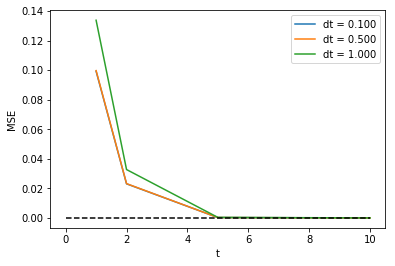

In [10]:
import numpy as np
FP_err = np.mean(FP_MSE, 2);
# plot error surface
fig = plt.figure();
for i in range(num_dts):
    plt.plot(t_ss_list, FP_err[:,i], label='dt = %.3f' % dts[i]);
plt.plot([0, max(t_ss_list)], [0, 0], 'k--');
plt.xlabel('t');
plt.ylabel('MSE');
plt.legend();
plt.show();
